In [2]:
##### Question 1 Codes #######

In [3]:
#Import the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#Use GPU if avaliable to reduce to required time to compute
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)


Device in use: cuda


In [4]:
# Transform the dataset into tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]


In [17]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1. Conv+ReLU+Pool
        x = self.pool(F.relu(self.conv2(x)))  # 2. Conv+ReLU+Pool
        x = x.view(-1, 64 * 7 * 7)            # Flatten  (Convert 2D to 1D )
        x = F.relu(self.fc1(x))               # Fully connected stage + ReLU
        x = self.dropout(x)                   # Dropout (Decreases the overfitting) (Resets the random neurons)
        x = self.fc2(x)                       # Output (10 class from 0 to 9)
        return x                              # We will complate the softmax by using cross-entropy


In [18]:
model = BaselineCNN().to(device)                     # Create the model and define to which device will used
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Higher lr causes unstable operation and lower lr causes increasing the training time


In [19]:
#Define the training and test functions
def train(model, device, train_loader, optimizer, criterion, epoch, log_interval=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % log_interval == 0:
            print(f'Epoch {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}')
    avg_loss = running_loss / len(train_loader)
    acc = 100. * correct / total
    return avg_loss, acc

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc


Epoch 1 [0/60000] Loss: 2.2962
Epoch 1 [6400/60000] Loss: 0.2937
Epoch 1 [12800/60000] Loss: 0.4419
Epoch 1 [19200/60000] Loss: 0.2014
Epoch 1 [25600/60000] Loss: 0.1084
Epoch 1 [32000/60000] Loss: 0.2997
Epoch 1 [38400/60000] Loss: 0.0339
Epoch 1 [44800/60000] Loss: 0.1457
Epoch 1 [51200/60000] Loss: 0.0417
Epoch 1 [57600/60000] Loss: 0.1231
Epoch 1 - Train Acc: 92.88%, Test Acc: 98.49%
Epoch 2 [0/60000] Loss: 0.0329
Epoch 2 [6400/60000] Loss: 0.2645
Epoch 2 [12800/60000] Loss: 0.1359
Epoch 2 [19200/60000] Loss: 0.1519
Epoch 2 [25600/60000] Loss: 0.0296
Epoch 2 [32000/60000] Loss: 0.0236
Epoch 2 [38400/60000] Loss: 0.1756
Epoch 2 [44800/60000] Loss: 0.0947
Epoch 2 [51200/60000] Loss: 0.0325
Epoch 2 [57600/60000] Loss: 0.0269
Epoch 2 - Train Acc: 97.52%, Test Acc: 98.89%
Epoch 3 [0/60000] Loss: 0.1031
Epoch 3 [6400/60000] Loss: 0.0391
Epoch 3 [12800/60000] Loss: 0.0084
Epoch 3 [19200/60000] Loss: 0.0824
Epoch 3 [25600/60000] Loss: 0.0239
Epoch 3 [32000/60000] Loss: 0.0567
Epoch 3 [3840

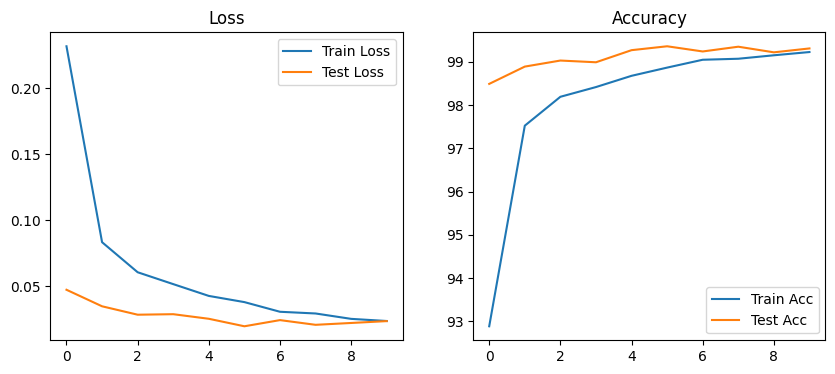

In [20]:
num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

#Calculate the values for each epoch
for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


In [ ]:
##### Question 2 Codes #######

In [21]:
#3 Convolution layer(32-64-128),1 FC(256) wider network capacity
class DeepWideCNN(nn.Module):
    def __init__(self):
        super(DeepWideCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [22]:
#Batch Normalization and LeakyReLU
class BatchNormLeakyCNN(nn.Module):
    def __init__(self):
        super(BatchNormLeakyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        self.act = nn.LeakyReLU(0.1)
    def forward(self, x):
        x = self.pool(self.act(self.bn1(self.conv1(x))))
        x = self.pool(self.act(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [23]:
#Different Kernels 1x1 and 5x5
class KernelVarCNN(nn.Module):
    def __init__(self):
        super(KernelVarCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 1)  # 1x1 kernel
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)  # 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Epoch 1 [0/60000] Loss: 2.3205
Epoch 1 [6400/60000] Loss: 0.2701
Epoch 1 [12800/60000] Loss: 0.1591
Epoch 1 [19200/60000] Loss: 0.2342
Epoch 1 [25600/60000] Loss: 0.0342
Epoch 1 [32000/60000] Loss: 0.0770
Epoch 1 [38400/60000] Loss: 0.0757
Epoch 1 [44800/60000] Loss: 0.0859
Epoch 1 [51200/60000] Loss: 0.0553
Epoch 1 [57600/60000] Loss: 0.0475
Epoch 1 - Train Acc: 94.52%, Test Acc: 98.63%
Epoch 2 [0/60000] Loss: 0.0387
Epoch 2 [6400/60000] Loss: 0.0487
Epoch 2 [12800/60000] Loss: 0.1049
Epoch 2 [19200/60000] Loss: 0.0202
Epoch 2 [25600/60000] Loss: 0.0144
Epoch 2 [32000/60000] Loss: 0.0862
Epoch 2 [38400/60000] Loss: 0.0700
Epoch 2 [44800/60000] Loss: 0.0641
Epoch 2 [51200/60000] Loss: 0.0693
Epoch 2 [57600/60000] Loss: 0.0564
Epoch 2 - Train Acc: 98.32%, Test Acc: 99.08%
Epoch 3 [0/60000] Loss: 0.0880
Epoch 3 [6400/60000] Loss: 0.0434
Epoch 3 [12800/60000] Loss: 0.0421
Epoch 3 [19200/60000] Loss: 0.0419
Epoch 3 [25600/60000] Loss: 0.1088
Epoch 3 [32000/60000] Loss: 0.0644
Epoch 3 [3840

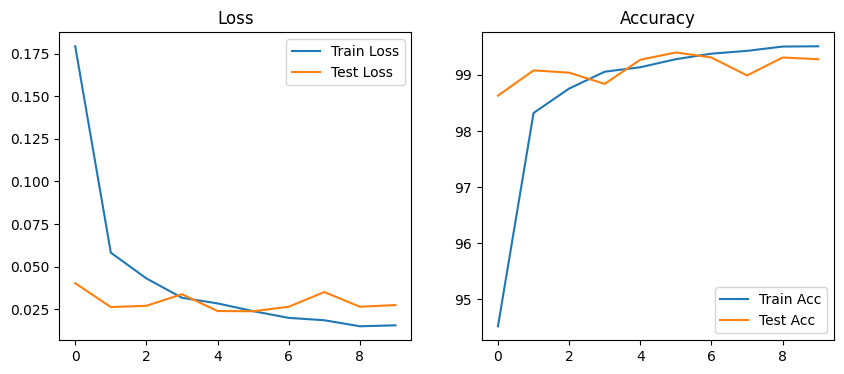

In [24]:
#Results for a Deeper CNN
model = DeepWideCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # To compare the results for the baseline CNN we kept the optimizer and loss fucntion same as baseline cnn
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


Epoch 1 [0/60000] Loss: 2.3152
Epoch 1 [6400/60000] Loss: 0.1747
Epoch 1 [12800/60000] Loss: 0.2432
Epoch 1 [19200/60000] Loss: 0.1166
Epoch 1 [25600/60000] Loss: 0.1586
Epoch 1 [32000/60000] Loss: 0.0815
Epoch 1 [38400/60000] Loss: 0.1138
Epoch 1 [44800/60000] Loss: 0.0159
Epoch 1 [51200/60000] Loss: 0.0483
Epoch 1 [57600/60000] Loss: 0.0254
Epoch 1 - Train Acc: 94.84%, Test Acc: 98.38%
Epoch 2 [0/60000] Loss: 0.1560
Epoch 2 [6400/60000] Loss: 0.0889
Epoch 2 [12800/60000] Loss: 0.0375
Epoch 2 [19200/60000] Loss: 0.0991
Epoch 2 [25600/60000] Loss: 0.1510
Epoch 2 [32000/60000] Loss: 0.1033
Epoch 2 [38400/60000] Loss: 0.0512
Epoch 2 [44800/60000] Loss: 0.0283
Epoch 2 [51200/60000] Loss: 0.2180
Epoch 2 [57600/60000] Loss: 0.1177
Epoch 2 - Train Acc: 97.77%, Test Acc: 98.97%
Epoch 3 [0/60000] Loss: 0.0073
Epoch 3 [6400/60000] Loss: 0.1291
Epoch 3 [12800/60000] Loss: 0.0263
Epoch 3 [19200/60000] Loss: 0.0703
Epoch 3 [25600/60000] Loss: 0.1017
Epoch 3 [32000/60000] Loss: 0.1363
Epoch 3 [3840

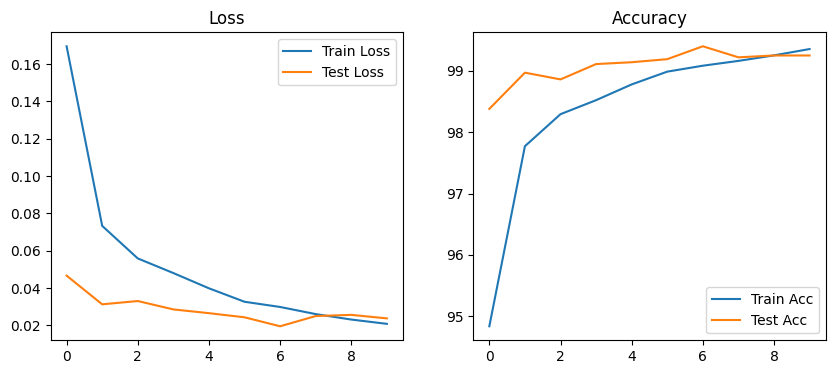

In [25]:
#Results for a CNN with Batch normalization and LeakyReLU
model = BatchNormLeakyCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # To compare the results for the baseline CNN we kept the optimizer and loss fucntion same as baseline cnn
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


Epoch 1 [0/60000] Loss: 2.3007
Epoch 1 [6400/60000] Loss: 0.2948
Epoch 1 [12800/60000] Loss: 0.3149
Epoch 1 [19200/60000] Loss: 0.1004
Epoch 1 [25600/60000] Loss: 0.2177
Epoch 1 [32000/60000] Loss: 0.1125
Epoch 1 [38400/60000] Loss: 0.0982
Epoch 1 [44800/60000] Loss: 0.0740
Epoch 1 [51200/60000] Loss: 0.0272
Epoch 1 [57600/60000] Loss: 0.1307
Epoch 1 - Train Acc: 91.73%, Test Acc: 97.44%
Epoch 2 [0/60000] Loss: 0.1859
Epoch 2 [6400/60000] Loss: 0.0811
Epoch 2 [12800/60000] Loss: 0.0229
Epoch 2 [19200/60000] Loss: 0.2801
Epoch 2 [25600/60000] Loss: 0.0896
Epoch 2 [32000/60000] Loss: 0.1059
Epoch 2 [38400/60000] Loss: 0.1135
Epoch 2 [44800/60000] Loss: 0.0560
Epoch 2 [51200/60000] Loss: 0.0225
Epoch 2 [57600/60000] Loss: 0.0441
Epoch 2 - Train Acc: 96.71%, Test Acc: 98.15%
Epoch 3 [0/60000] Loss: 0.0864
Epoch 3 [6400/60000] Loss: 0.0707
Epoch 3 [12800/60000] Loss: 0.1610
Epoch 3 [19200/60000] Loss: 0.1118
Epoch 3 [25600/60000] Loss: 0.0526
Epoch 3 [32000/60000] Loss: 0.0444
Epoch 3 [3840

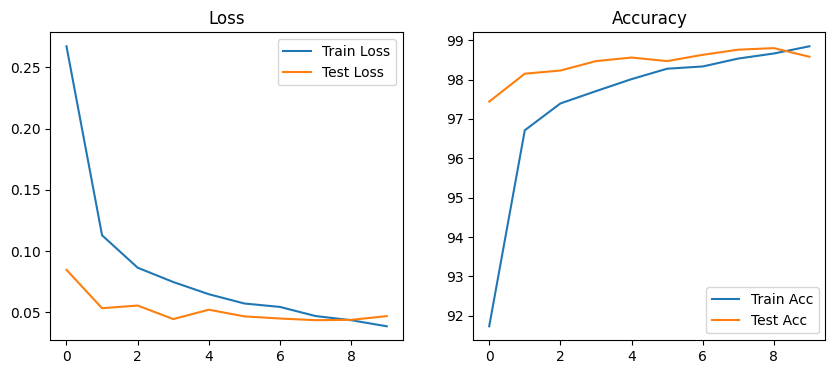

In [26]:
#Results for different Kernel sizes
model = KernelVarCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # To compare the results for the baseline CNN we kept the optimizer and loss fucntion same as baseline cnn
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


In [27]:
##### Question 3 Codes #######
#To compare the effects of the different configurations the baselineCNN model is used as a reference model

Epoch 1 [0/60000] Loss: 2.3163
Epoch 1 [6400/60000] Loss: 2.3041
Epoch 1 [12800/60000] Loss: 2.3095
Epoch 1 [19200/60000] Loss: 2.3051
Epoch 1 [25600/60000] Loss: 2.3016
Epoch 1 [32000/60000] Loss: 2.3076
Epoch 1 [38400/60000] Loss: 2.2944
Epoch 1 [44800/60000] Loss: 2.2944
Epoch 1 [51200/60000] Loss: 2.3038
Epoch 1 [57600/60000] Loss: 2.3067
Epoch 1 - Train Acc: 10.97%, Test Acc: 11.35%
Epoch 2 [0/60000] Loss: 2.2952
Epoch 2 [6400/60000] Loss: 2.3042
Epoch 2 [12800/60000] Loss: 2.3037
Epoch 2 [19200/60000] Loss: 2.2933
Epoch 2 [25600/60000] Loss: 2.2933
Epoch 2 [32000/60000] Loss: 2.3115
Epoch 2 [38400/60000] Loss: 2.2905
Epoch 2 [44800/60000] Loss: 2.3144
Epoch 2 [51200/60000] Loss: 2.2851
Epoch 2 [57600/60000] Loss: 2.3058
Epoch 2 - Train Acc: 11.03%, Test Acc: 11.35%
Epoch 3 [0/60000] Loss: 2.2925
Epoch 3 [6400/60000] Loss: 2.3087
Epoch 3 [12800/60000] Loss: 2.2925
Epoch 3 [19200/60000] Loss: 2.3120
Epoch 3 [25600/60000] Loss: 2.2875
Epoch 3 [32000/60000] Loss: 2.3133
Epoch 3 [3840

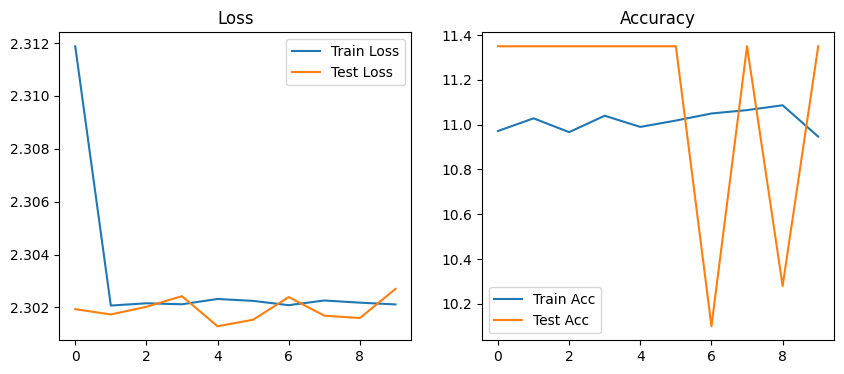

In [28]:
#Different learning rates for lr=0.01
model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


Epoch 1 [0/60000] Loss: 2.3012
Epoch 1 [6400/60000] Loss: 2.3236
Epoch 1 [12800/60000] Loss: 2.3331
Epoch 1 [19200/60000] Loss: 2.3042
Epoch 1 [25600/60000] Loss: 2.3235
Epoch 1 [32000/60000] Loss: 2.3014
Epoch 1 [38400/60000] Loss: 2.2989
Epoch 1 [44800/60000] Loss: 2.3101
Epoch 1 [51200/60000] Loss: 2.3123
Epoch 1 [57600/60000] Loss: 2.3006
Epoch 1 - Train Acc: 10.30%, Test Acc: 10.28%
Epoch 2 [0/60000] Loss: 2.2793
Epoch 2 [6400/60000] Loss: 2.3442
Epoch 2 [12800/60000] Loss: 2.2982
Epoch 2 [19200/60000] Loss: 2.3112
Epoch 2 [25600/60000] Loss: 2.3250
Epoch 2 [32000/60000] Loss: 2.2882
Epoch 2 [38400/60000] Loss: 2.3111
Epoch 2 [44800/60000] Loss: 2.3027
Epoch 2 [51200/60000] Loss: 2.3528
Epoch 2 [57600/60000] Loss: 2.2989
Epoch 2 - Train Acc: 10.27%, Test Acc: 11.35%
Epoch 3 [0/60000] Loss: 2.3046
Epoch 3 [6400/60000] Loss: 2.2848
Epoch 3 [12800/60000] Loss: 2.3147
Epoch 3 [19200/60000] Loss: 2.3153
Epoch 3 [25600/60000] Loss: 2.3201
Epoch 3 [32000/60000] Loss: 2.3372
Epoch 3 [3840

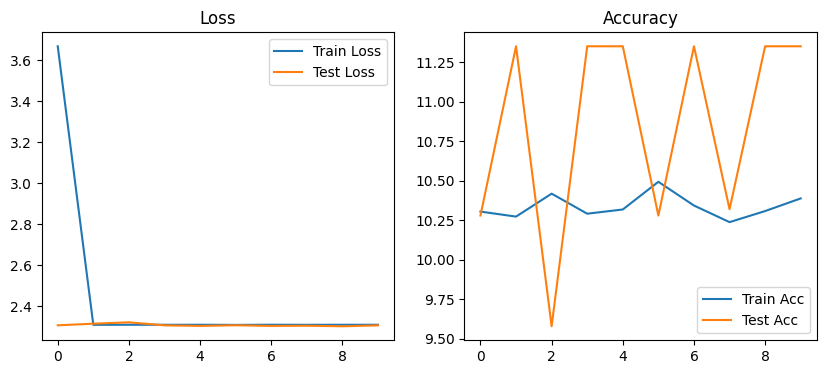

In [29]:
#Different learning rates for lr=0.1
model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1 [0/60000] Loss: 2.3082
Epoch 1 [6400/60000] Loss: 1.0221
Epoch 1 [12800/60000] Loss: 0.5299
Epoch 1 [19200/60000] Loss: 0.4493
Epoch 1 [25600/60000] Loss: 0.2943
Epoch 1 [32000/60000] Loss: 0.2138
Epoch 1 [38400/60000] Loss: 0.1510
Epoch 1 [44800/60000] Loss: 0.2222
Epoch 1 [51200/60000] Loss: 0.1191
Epoch 1 [57600/60000] Loss: 0.0681
Epoch 1 - Train Acc: 85.81%, Test Acc: 96.29%
Epoch 2 [0/60000] Loss: 0.2874
Epoch 2 [6400/60000] Loss: 0.1966
Epoch 2 [12800/60000] Loss: 0.1523
Epoch 2 [19200/60000] Loss: 0.2185
Epoch 2 [25600/60000] Loss: 0.1410
Epoch 2 [32000/60000] Loss: 0.2519
Epoch 2 [38400/60000] Loss: 0.1160
Epoch 2 [44800/60000] Loss: 0.1004
Epoch 2 [51200/60000] Loss: 0.0621
Epoch 2 [57600/60000] Loss: 0.2564
Epoch 2 - Train Acc: 95.40%, Test Acc: 97.71%
Epoch 3 [0/60000] Loss: 0.0827
Epoch 3 [6400/60000] Loss: 0.1374
Epoch 3 [12800/60000] Loss: 0.1764
Epoch 3 [19200/60000] Loss: 0.0863
Epoch 3 [25600/60000] Loss: 0.1450
Epoch 3 [32000/60000] Loss: 0.1548
Epoch 3 [3840

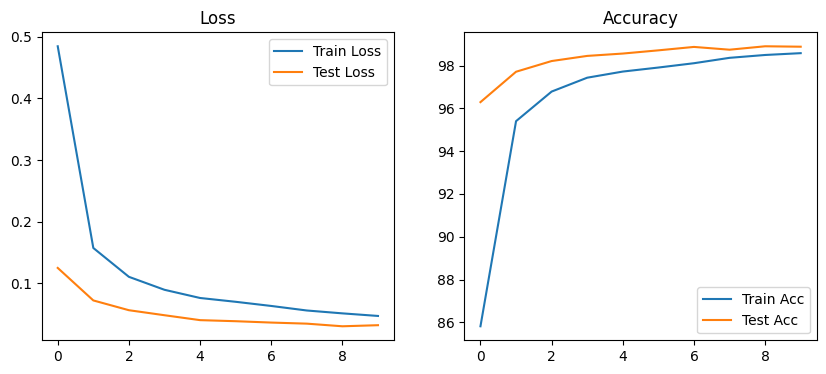

In [30]:
#Different learning rates for lr=0.0001
model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1 [0/60000] Loss: 2.3340
Epoch 1 [6400/60000] Loss: 0.3299
Epoch 1 [12800/60000] Loss: 0.3026
Epoch 1 [19200/60000] Loss: 0.1742
Epoch 1 [25600/60000] Loss: 0.2257
Epoch 1 [32000/60000] Loss: 0.0665
Epoch 1 [38400/60000] Loss: 0.2953
Epoch 1 [44800/60000] Loss: 0.0911
Epoch 1 [51200/60000] Loss: 0.0992
Epoch 1 [57600/60000] Loss: 0.1940
Epoch 1 - Train Acc: 92.70%, Test Acc: 98.28%
Epoch 2 [0/60000] Loss: 0.2511
Epoch 2 [6400/60000] Loss: 0.1156
Epoch 2 [12800/60000] Loss: 0.1269
Epoch 2 [19200/60000] Loss: 0.0681
Epoch 2 [25600/60000] Loss: 0.0581
Epoch 2 [32000/60000] Loss: 0.0307
Epoch 2 [38400/60000] Loss: 0.2057
Epoch 2 [44800/60000] Loss: 0.0419
Epoch 2 [51200/60000] Loss: 0.2284
Epoch 2 [57600/60000] Loss: 0.0375
Epoch 2 - Train Acc: 97.33%, Test Acc: 98.82%
Epoch 3 [0/60000] Loss: 0.0174
Epoch 3 [6400/60000] Loss: 0.0881
Epoch 3 [12800/60000] Loss: 0.1517
Epoch 3 [19200/60000] Loss: 0.0410
Epoch 3 [25600/60000] Loss: 0.1293
Epoch 3 [32000/60000] Loss: 0.0862
Epoch 3 [3840

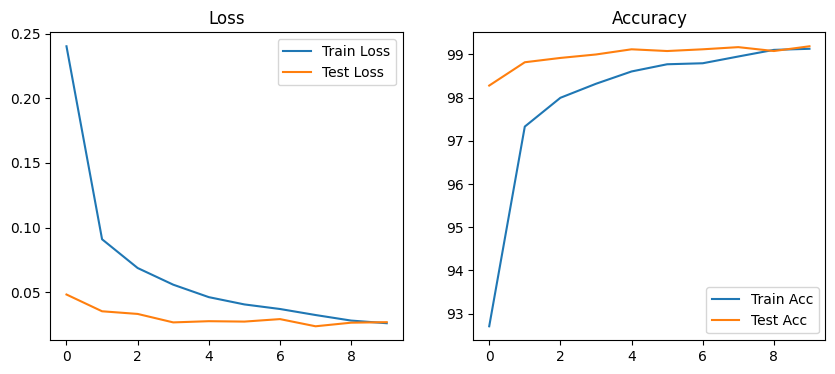

In [31]:
#Different optimizer types for Adam
model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1 [0/60000] Loss: 2.3134
Epoch 1 [3200/60000] Loss: 0.1887
Epoch 1 [6400/60000] Loss: 0.3078
Epoch 1 [9600/60000] Loss: 0.1285
Epoch 1 [12800/60000] Loss: 0.2717
Epoch 1 [16000/60000] Loss: 0.1938
Epoch 1 [19200/60000] Loss: 0.4279
Epoch 1 [22400/60000] Loss: 0.5450
Epoch 1 [25600/60000] Loss: 0.2197
Epoch 1 [28800/60000] Loss: 0.4098
Epoch 1 [32000/60000] Loss: 0.0262
Epoch 1 [35200/60000] Loss: 0.1002
Epoch 1 [38400/60000] Loss: 0.1124
Epoch 1 [41600/60000] Loss: 0.0750
Epoch 1 [44800/60000] Loss: 0.0421
Epoch 1 [48000/60000] Loss: 0.0674
Epoch 1 [51200/60000] Loss: 0.1469
Epoch 1 [54400/60000] Loss: 0.0629
Epoch 1 [57600/60000] Loss: 0.1293
Epoch 1 - Train Acc: 92.93%, Test Acc: 98.08%
Epoch 2 [0/60000] Loss: 0.0337
Epoch 2 [3200/60000] Loss: 0.0989
Epoch 2 [6400/60000] Loss: 0.0234
Epoch 2 [9600/60000] Loss: 0.0303
Epoch 2 [12800/60000] Loss: 0.1997
Epoch 2 [16000/60000] Loss: 0.1612
Epoch 2 [19200/60000] Loss: 0.0079
Epoch 2 [22400/60000] Loss: 0.3907
Epoch 2 [25600/60000] L

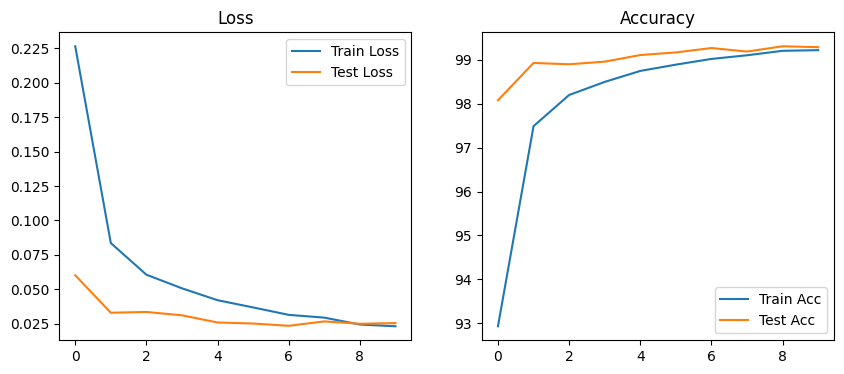

In [33]:
#Different optimizer types for SGD
model = BaselineCNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #Note that learning rate is different from the Adam optimizer since SGD learns slowly with smaller learning rates
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1 [0/60000] Loss: 2.3463
Epoch 1 [3200/60000] Loss: 0.2451
Epoch 1 [6400/60000] Loss: 0.1484
Epoch 1 [9600/60000] Loss: 0.2916
Epoch 1 [12800/60000] Loss: 0.2275
Epoch 1 [16000/60000] Loss: 0.1572
Epoch 1 [19200/60000] Loss: 0.1047
Epoch 1 [22400/60000] Loss: 0.0739
Epoch 1 [25600/60000] Loss: 0.1997
Epoch 1 [28800/60000] Loss: 0.1918
Epoch 1 [32000/60000] Loss: 0.1443
Epoch 1 [35200/60000] Loss: 0.2582
Epoch 1 [38400/60000] Loss: 0.2768
Epoch 1 [41600/60000] Loss: 0.1361
Epoch 1 [44800/60000] Loss: 0.0911
Epoch 1 [48000/60000] Loss: 0.1687
Epoch 1 [51200/60000] Loss: 0.1033
Epoch 1 [54400/60000] Loss: 0.2188
Epoch 1 [57600/60000] Loss: 0.0836
Epoch 1 - Train Acc: 94.31%, Test Acc: 98.46%
Epoch 2 [0/60000] Loss: 0.0069
Epoch 2 [3200/60000] Loss: 0.0773
Epoch 2 [6400/60000] Loss: 0.0726
Epoch 2 [9600/60000] Loss: 0.0072
Epoch 2 [12800/60000] Loss: 0.1716
Epoch 2 [16000/60000] Loss: 0.0075
Epoch 2 [19200/60000] Loss: 0.0548
Epoch 2 [22400/60000] Loss: 0.1041
Epoch 2 [25600/60000] L

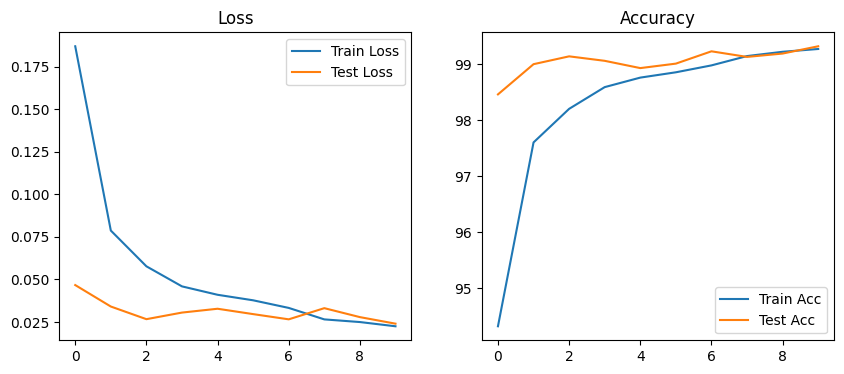

In [34]:
#Results for different batch sizes
#Note that we only change the train_loader batch size since there is a significant effect on the model accuracy. We didn't change the test_loader batch size because it only effects the test time no need to change size.
# batch_size=32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


Epoch 1 [0/60000] Loss: 2.3090
Epoch 1 [6400/60000] Loss: 0.1254
Epoch 1 [12800/60000] Loss: 0.1765
Epoch 1 [19200/60000] Loss: 0.0588
Epoch 1 [25600/60000] Loss: 0.1434
Epoch 1 [32000/60000] Loss: 0.0698
Epoch 1 [38400/60000] Loss: 0.0261
Epoch 1 [44800/60000] Loss: 0.0710
Epoch 1 [51200/60000] Loss: 0.0889
Epoch 1 [57600/60000] Loss: 0.1295
Epoch 1 - Train Acc: 92.87%, Test Acc: 98.35%
Epoch 2 [0/60000] Loss: 0.1217
Epoch 2 [6400/60000] Loss: 0.0477
Epoch 2 [12800/60000] Loss: 0.1925
Epoch 2 [19200/60000] Loss: 0.0589
Epoch 2 [25600/60000] Loss: 0.0852
Epoch 2 [32000/60000] Loss: 0.0406
Epoch 2 [38400/60000] Loss: 0.0692
Epoch 2 [44800/60000] Loss: 0.0573
Epoch 2 [51200/60000] Loss: 0.0220
Epoch 2 [57600/60000] Loss: 0.0372
Epoch 2 - Train Acc: 97.33%, Test Acc: 98.60%
Epoch 3 [0/60000] Loss: 0.1095
Epoch 3 [6400/60000] Loss: 0.0252
Epoch 3 [12800/60000] Loss: 0.0694
Epoch 3 [19200/60000] Loss: 0.1686
Epoch 3 [25600/60000] Loss: 0.0432
Epoch 3 [32000/60000] Loss: 0.0055
Epoch 3 [3840

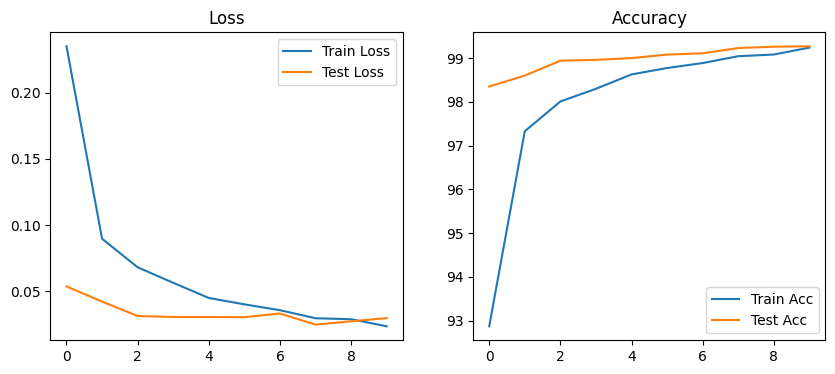

In [35]:
#Results for different batch sizes
# batch_size=64(reference model has that value)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


Epoch 1 [0/60000] Loss: 2.3093
Epoch 1 [12800/60000] Loss: 0.3016
Epoch 1 [25600/60000] Loss: 0.1610
Epoch 1 [38400/60000] Loss: 0.2965
Epoch 1 [51200/60000] Loss: 0.1776
Epoch 1 - Train Acc: 91.53%, Test Acc: 98.42%
Epoch 2 [0/60000] Loss: 0.1273
Epoch 2 [12800/60000] Loss: 0.0492
Epoch 2 [25600/60000] Loss: 0.0420
Epoch 2 [38400/60000] Loss: 0.0660
Epoch 2 [51200/60000] Loss: 0.0674
Epoch 2 - Train Acc: 97.45%, Test Acc: 98.56%
Epoch 3 [0/60000] Loss: 0.0568
Epoch 3 [12800/60000] Loss: 0.0845
Epoch 3 [25600/60000] Loss: 0.0482
Epoch 3 [38400/60000] Loss: 0.0643
Epoch 3 [51200/60000] Loss: 0.0233
Epoch 3 - Train Acc: 98.05%, Test Acc: 99.02%
Epoch 4 [0/60000] Loss: 0.0770
Epoch 4 [12800/60000] Loss: 0.0921
Epoch 4 [25600/60000] Loss: 0.0136
Epoch 4 [38400/60000] Loss: 0.0435
Epoch 4 [51200/60000] Loss: 0.0173
Epoch 4 - Train Acc: 98.46%, Test Acc: 99.04%
Epoch 5 [0/60000] Loss: 0.0531
Epoch 5 [12800/60000] Loss: 0.0168
Epoch 5 [25600/60000] Loss: 0.0246
Epoch 5 [38400/60000] Loss: 0.0

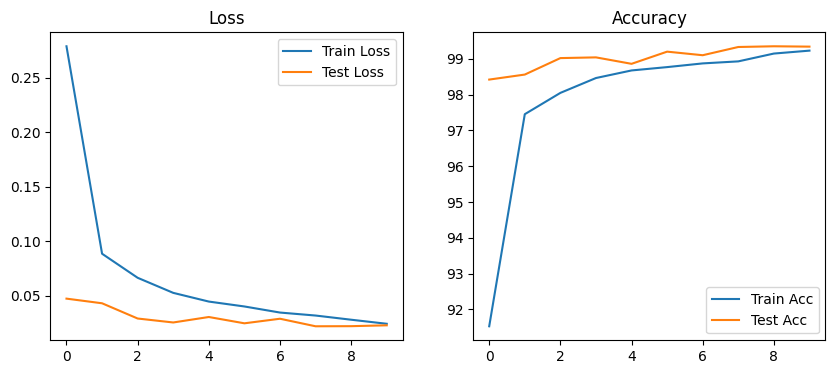

In [36]:
#Results for different batch sizes
# batch_size=128
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1 [0/60000] Loss: 2.3057
Epoch 1 [12800/60000] Loss: 0.1187
Epoch 1 [25600/60000] Loss: 0.0717
Epoch 1 [38400/60000] Loss: 0.1235
Epoch 1 [51200/60000] Loss: 0.0969
Epoch 1 - Train Acc: 94.34%, Test Acc: 98.29%
Epoch 2 [0/60000] Loss: 0.0558
Epoch 2 [12800/60000] Loss: 0.0675
Epoch 2 [25600/60000] Loss: 0.0097
Epoch 2 [38400/60000] Loss: 0.0362
Epoch 2 [51200/60000] Loss: 0.0529
Epoch 2 - Train Acc: 98.31%, Test Acc: 98.79%
Epoch 3 [0/60000] Loss: 0.0174
Epoch 3 [12800/60000] Loss: 0.0211
Epoch 3 [25600/60000] Loss: 0.0525
Epoch 3 [38400/60000] Loss: 0.0688
Epoch 3 [51200/60000] Loss: 0.0422
Epoch 3 - Train Acc: 98.88%, Test Acc: 99.00%
Epoch 4 [0/60000] Loss: 0.0134
Epoch 4 [12800/60000] Loss: 0.0276
Epoch 4 [25600/60000] Loss: 0.0319
Epoch 4 [38400/60000] Loss: 0.0388
Epoch 4 [51200/60000] Loss: 0.0455
Epoch 4 - Train Acc: 99.10%, Test Acc: 99.16%
Epoch 5 [0/60000] Loss: 0.0645
Epoch 5 [12800/60000] Loss: 0.0122
Epoch 5 [25600/60000] Loss: 0.0193
Epoch 5 [38400/60000] Loss: 0.0

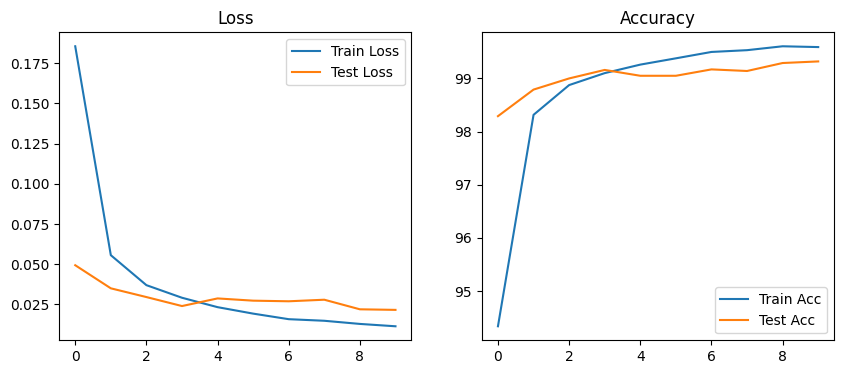

In [37]:
#Results for different dropout rates (for 0.2)
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1. Conv+ReLU+Pool
        x = self.pool(F.relu(self.conv2(x)))  # 2. Conv+ReLU+Pool
        x = x.view(-1, 64 * 7 * 7)            # Flatten  (Convert 2D to 1D )
        x = F.relu(self.fc1(x))               # Fully connected stage + ReLU
        x = self.dropout(x)                   # Dropout (Decreases the overfitting) (Resets the random neurons)
        x = self.fc2(x)                       # Output (10 class from 0 to 9)
        return x                              # We will complate the softmax by using cross-entropy


model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1 [0/60000] Loss: 2.3019
Epoch 1 [12800/60000] Loss: 0.5770
Epoch 1 [25600/60000] Loss: 0.2022
Epoch 1 [38400/60000] Loss: 0.0905
Epoch 1 [51200/60000] Loss: 0.0888
Epoch 1 - Train Acc: 92.00%, Test Acc: 98.24%
Epoch 2 [0/60000] Loss: 0.0725
Epoch 2 [12800/60000] Loss: 0.0780
Epoch 2 [25600/60000] Loss: 0.0783
Epoch 2 [38400/60000] Loss: 0.0728
Epoch 2 [51200/60000] Loss: 0.1853
Epoch 2 - Train Acc: 97.30%, Test Acc: 98.64%
Epoch 3 [0/60000] Loss: 0.0671
Epoch 3 [12800/60000] Loss: 0.0636
Epoch 3 [25600/60000] Loss: 0.1733
Epoch 3 [38400/60000] Loss: 0.0446
Epoch 3 [51200/60000] Loss: 0.0320
Epoch 3 - Train Acc: 97.92%, Test Acc: 98.95%
Epoch 4 [0/60000] Loss: 0.0365
Epoch 4 [12800/60000] Loss: 0.0400
Epoch 4 [25600/60000] Loss: 0.0833
Epoch 4 [38400/60000] Loss: 0.0437
Epoch 4 [51200/60000] Loss: 0.0375
Epoch 4 - Train Acc: 98.23%, Test Acc: 98.91%
Epoch 5 [0/60000] Loss: 0.0143
Epoch 5 [12800/60000] Loss: 0.0792
Epoch 5 [25600/60000] Loss: 0.0138
Epoch 5 [38400/60000] Loss: 0.0

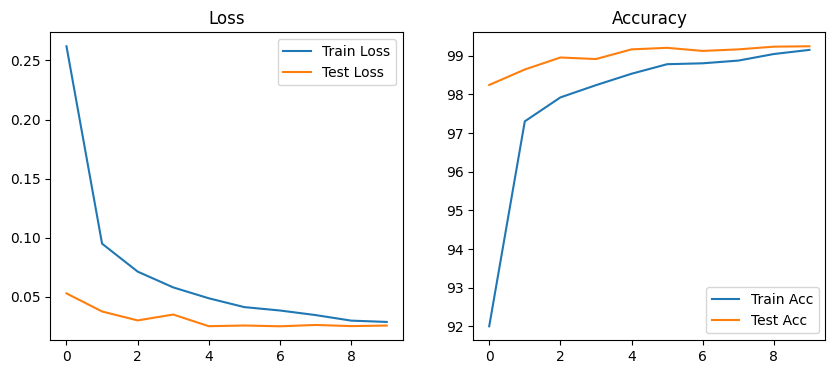

In [39]:
#Results for different dropout rates (for 0.5)(reference)
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1. Conv+ReLU+Pool
        x = self.pool(F.relu(self.conv2(x)))  # 2. Conv+ReLU+Pool
        x = x.view(-1, 64 * 7 * 7)            # Flatten  (Convert 2D to 1D )
        x = F.relu(self.fc1(x))               # Fully connected stage + ReLU
        x = self.dropout(x)                   # Dropout (Decreases the overfitting) (Resets the random neurons)
        x = self.fc2(x)                       # Output (10 class from 0 to 9)
        return x                              # We will complate the softmax by using cross-entropy


model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1 [0/60000] Loss: 2.3087
Epoch 1 [12800/60000] Loss: 0.6995
Epoch 1 [25600/60000] Loss: 0.7002
Epoch 1 [38400/60000] Loss: 0.4134
Epoch 1 [51200/60000] Loss: 0.4393
Epoch 1 - Train Acc: 76.00%, Test Acc: 97.61%
Epoch 2 [0/60000] Loss: 0.5140
Epoch 2 [12800/60000] Loss: 0.4955
Epoch 2 [25600/60000] Loss: 0.2159
Epoch 2 [38400/60000] Loss: 0.2547
Epoch 2 [51200/60000] Loss: 0.3030
Epoch 2 - Train Acc: 87.42%, Test Acc: 98.30%
Epoch 3 [0/60000] Loss: 0.4199
Epoch 3 [12800/60000] Loss: 0.2752
Epoch 3 [25600/60000] Loss: 0.2750
Epoch 3 [38400/60000] Loss: 0.3935
Epoch 3 [51200/60000] Loss: 0.2868
Epoch 3 - Train Acc: 89.25%, Test Acc: 98.50%
Epoch 4 [0/60000] Loss: 0.2043
Epoch 4 [12800/60000] Loss: 0.2080
Epoch 4 [25600/60000] Loss: 0.3205
Epoch 4 [38400/60000] Loss: 0.2271
Epoch 4 [51200/60000] Loss: 0.2373
Epoch 4 - Train Acc: 90.75%, Test Acc: 98.84%
Epoch 5 [0/60000] Loss: 0.2712
Epoch 5 [12800/60000] Loss: 0.1683
Epoch 5 [25600/60000] Loss: 0.2062
Epoch 5 [38400/60000] Loss: 0.1

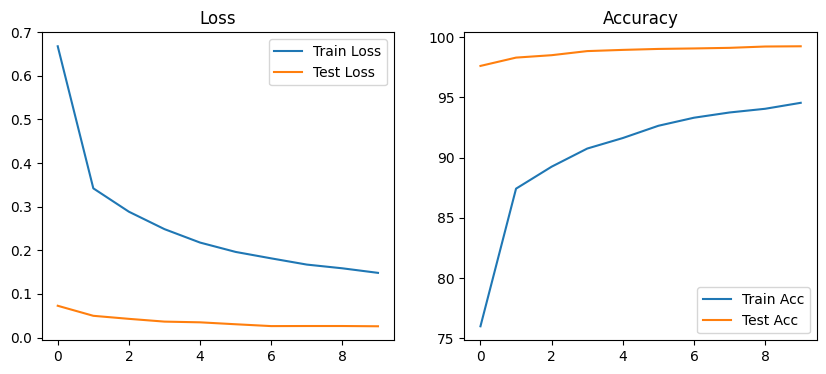

In [38]:
#Results for different dropout rates (for 0.8)
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.8)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1. Conv+ReLU+Pool
        x = self.pool(F.relu(self.conv2(x)))  # 2. Conv+ReLU+Pool
        x = x.view(-1, 64 * 7 * 7)            # Flatten  (Convert 2D to 1D )
        x = F.relu(self.fc1(x))               # Fully connected stage + ReLU
        x = self.dropout(x)                   # Dropout (Decreases the overfitting) (Resets the random neurons)
        x = self.fc2(x)                       # Output (10 class from 0 to 9)
        return x                              # We will complate the softmax by using cross-entropy


model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1 [0/60000] Loss: 2.3700
Epoch 1 [12800/60000] Loss: 0.2455
Epoch 1 [25600/60000] Loss: 0.0921
Epoch 1 [38400/60000] Loss: 0.0960
Epoch 1 [51200/60000] Loss: 0.2533
Epoch 1 - Train Acc: 91.71%, Test Acc: 98.36%
Epoch 2 [0/60000] Loss: 0.0774
Epoch 2 [12800/60000] Loss: 0.0357
Epoch 2 [25600/60000] Loss: 0.1327
Epoch 2 [38400/60000] Loss: 0.0510
Epoch 2 [51200/60000] Loss: 0.0366
Epoch 2 - Train Acc: 97.36%, Test Acc: 98.77%
Epoch 3 [0/60000] Loss: 0.0368
Epoch 3 [12800/60000] Loss: 0.0403
Epoch 3 [25600/60000] Loss: 0.0327
Epoch 3 [38400/60000] Loss: 0.0401
Epoch 3 [51200/60000] Loss: 0.0566
Epoch 3 - Train Acc: 98.11%, Test Acc: 98.99%
Epoch 4 [0/60000] Loss: 0.0155
Epoch 4 [12800/60000] Loss: 0.0411
Epoch 4 [25600/60000] Loss: 0.0926
Epoch 4 [38400/60000] Loss: 0.0109
Epoch 4 [51200/60000] Loss: 0.0132
Epoch 4 - Train Acc: 98.52%, Test Acc: 99.06%
Epoch 5 [0/60000] Loss: 0.0725
Epoch 5 [12800/60000] Loss: 0.0186
Epoch 5 [25600/60000] Loss: 0.0577
Epoch 5 [38400/60000] Loss: 0.0

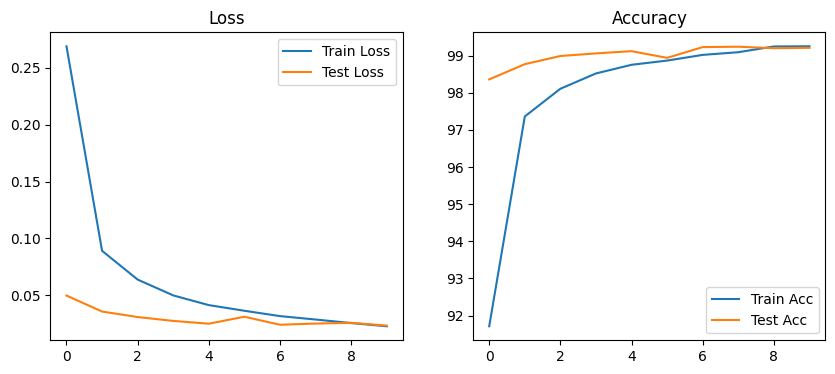

In [40]:
#Results for different weight initialization (for Xavier(Glorot))
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1. Conv+ReLU+Pool
        x = self.pool(F.relu(self.conv2(x)))  # 2. Conv+ReLU+Pool
        x = x.view(-1, 64 * 7 * 7)            # Flatten  (Convert 2D to 1D )
        x = F.relu(self.fc1(x))               # Fully connected stage + ReLU
        x = self.dropout(x)                   # Dropout (Decreases the overfitting) (Resets the random neurons)
        x = self.fc2(x)                       # Output (10 class from 0 to 9)
        return x                              # We will complate the softmax by using cross-entropy


def xavier_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = BaselineCNN().to(device)
model.apply(xavier_init)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()



Epoch 1 [0/60000] Loss: 4.3817
Epoch 1 [12800/60000] Loss: 0.4026
Epoch 1 [25600/60000] Loss: 0.2832
Epoch 1 [38400/60000] Loss: 0.3240
Epoch 1 [51200/60000] Loss: 0.2093
Epoch 1 - Train Acc: 88.64%, Test Acc: 98.32%
Epoch 2 [0/60000] Loss: 0.1384
Epoch 2 [12800/60000] Loss: 0.1943
Epoch 2 [25600/60000] Loss: 0.1191
Epoch 2 [38400/60000] Loss: 0.2239
Epoch 2 [51200/60000] Loss: 0.1180
Epoch 2 - Train Acc: 96.37%, Test Acc: 98.58%
Epoch 3 [0/60000] Loss: 0.0309
Epoch 3 [12800/60000] Loss: 0.0415
Epoch 3 [25600/60000] Loss: 0.0659
Epoch 3 [38400/60000] Loss: 0.0765
Epoch 3 [51200/60000] Loss: 0.0493
Epoch 3 - Train Acc: 97.61%, Test Acc: 98.85%
Epoch 4 [0/60000] Loss: 0.0979
Epoch 4 [12800/60000] Loss: 0.0214
Epoch 4 [25600/60000] Loss: 0.2210
Epoch 4 [38400/60000] Loss: 0.0129
Epoch 4 [51200/60000] Loss: 0.0230
Epoch 4 - Train Acc: 98.03%, Test Acc: 99.02%
Epoch 5 [0/60000] Loss: 0.0960
Epoch 5 [12800/60000] Loss: 0.0754
Epoch 5 [25600/60000] Loss: 0.0481
Epoch 5 [38400/60000] Loss: 0.0

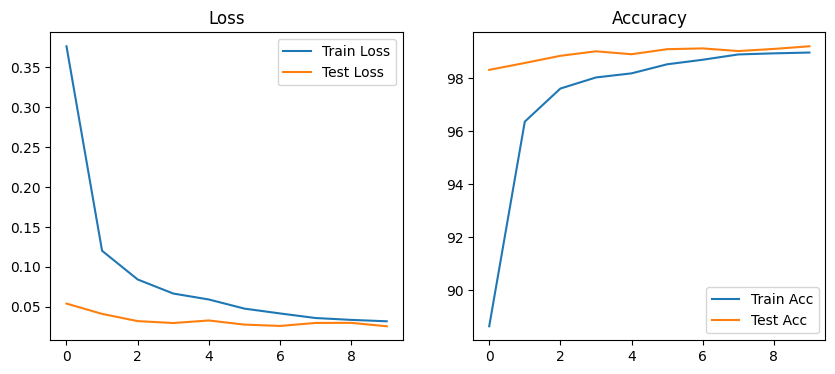

In [41]:
#Results for different weight initialization (for He(Kaiming))
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1. Conv+ReLU+Pool
        x = self.pool(F.relu(self.conv2(x)))  # 2. Conv+ReLU+Pool
        x = x.view(-1, 64 * 7 * 7)            # Flatten  (Convert 2D to 1D )
        x = F.relu(self.fc1(x))               # Fully connected stage + ReLU
        x = self.dropout(x)                   # Dropout (Decreases the overfitting) (Resets the random neurons)
        x = self.fc2(x)                       # Output (10 class from 0 to 9)
        return x                              # We will complate the softmax by using cross-entropy


def kaiming_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = BaselineCNN().to(device)
model.apply(kaiming_init)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()



In [ ]:
##### Question 4 Codes #######

Epoch 1 [0/60000] Loss: 2.3342
Epoch 1 [12800/60000] Loss: 1.7687
Epoch 1 [25600/60000] Loss: 1.5268
Epoch 1 [38400/60000] Loss: 1.5679
Epoch 1 [51200/60000] Loss: 1.4876
Epoch 1 - Train Acc: 28.17%, Test Acc: 95.69%
Epoch 2 [0/60000] Loss: 1.5314
Epoch 2 [12800/60000] Loss: 1.4417
Epoch 2 [25600/60000] Loss: 1.5254
Epoch 2 [38400/60000] Loss: 1.5789
Epoch 2 [51200/60000] Loss: 1.3613
Epoch 2 - Train Acc: 34.48%, Test Acc: 97.02%
Epoch 3 [0/60000] Loss: 1.5003
Epoch 3 [12800/60000] Loss: 1.6011
Epoch 3 [25600/60000] Loss: 1.4238
Epoch 3 [38400/60000] Loss: 1.4952
Epoch 3 [51200/60000] Loss: 1.5513
Epoch 3 - Train Acc: 35.55%, Test Acc: 97.44%
Epoch 4 [0/60000] Loss: 1.5823
Epoch 4 [12800/60000] Loss: 1.4318
Epoch 4 [25600/60000] Loss: 1.4403
Epoch 4 [38400/60000] Loss: 1.3575
Epoch 4 [51200/60000] Loss: 1.5473
Epoch 4 - Train Acc: 37.10%, Test Acc: 97.67%
Epoch 5 [0/60000] Loss: 1.3416
Epoch 5 [12800/60000] Loss: 1.4909
Epoch 5 [25600/60000] Loss: 1.3966
Epoch 5 [38400/60000] Loss: 1.3

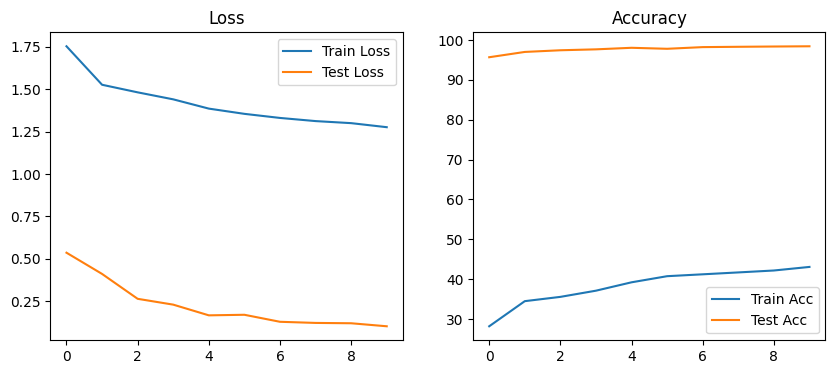

In [42]:
#High Dropout rate (for 0.95)
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.95)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1. Conv+ReLU+Pool
        x = self.pool(F.relu(self.conv2(x)))  # 2. Conv+ReLU+Pool
        x = x.view(-1, 64 * 7 * 7)            # Flatten  (Convert 2D to 1D )
        x = F.relu(self.fc1(x))               # Fully connected stage + ReLU
        x = self.dropout(x)                   # Dropout (Decreases the overfitting) (Resets the random neurons)
        x = self.fc2(x)                       # Output (10 class from 0 to 9)
        return x                              # We will complate the softmax by using cross-entropy


model = BaselineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

Epoch 1 [0/60000] Loss: 1031917731840.0000
Epoch 1 [12800/60000] Loss: 876417253376.0000
Epoch 1 [25600/60000] Loss: 817129193472.0000
Epoch 1 [38400/60000] Loss: 775901282304.0000
Epoch 1 [51200/60000] Loss: 879777873920.0000
Epoch 1 - Train Acc: 10.31%, Test Acc: 9.80%
Epoch 2 [0/60000] Loss: 739699523584.0000
Epoch 2 [12800/60000] Loss: 672159760384.0000
Epoch 2 [25600/60000] Loss: 789659385856.0000
Epoch 2 [38400/60000] Loss: 571853504512.0000
Epoch 2 [51200/60000] Loss: 625568710656.0000
Epoch 2 - Train Acc: 10.36%, Test Acc: 9.80%
Epoch 3 [0/60000] Loss: 646981156864.0000
Epoch 3 [12800/60000] Loss: 565558378496.0000
Epoch 3 [25600/60000] Loss: 641468727296.0000
Epoch 3 [38400/60000] Loss: 646836322304.0000
Epoch 3 [51200/60000] Loss: 628791443456.0000
Epoch 3 - Train Acc: 10.34%, Test Acc: 9.80%
Epoch 4 [0/60000] Loss: 630680715264.0000
Epoch 4 [12800/60000] Loss: 627464077312.0000
Epoch 4 [25600/60000] Loss: 619057905664.0000
Epoch 4 [38400/60000] Loss: 504145248256.0000
Epoch 

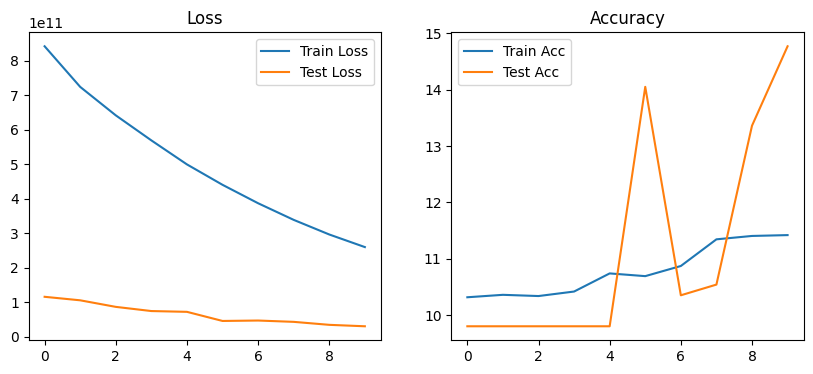

In [43]:
#Random or False Weight Initialization
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1. Conv+ReLU+Pool
        x = self.pool(F.relu(self.conv2(x)))  # 2. Conv+ReLU+Pool
        x = x.view(-1, 64 * 7 * 7)            # Flatten  (Convert 2D to 1D )
        x = F.relu(self.fc1(x))               # Fully connected stage + ReLU
        x = self.dropout(x)                   # Dropout (Decreases the overfitting) (Resets the random neurons)
        x = self.fc2(x)                       # Output (10 class from 0 to 9)
        return x                              # We will complate the softmax by using cross-entropy


import torch.nn.init as init
def bad_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.uniform_(m.weight, a=10.0, b=20.0)  # Aşırı büyük ve saçma aralık
        if m.bias is not None:
            init.constant_(m.bias, 0)
model = BaselineCNN().to(device)
model.apply(bad_init)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, criterion, epoch)
    te_loss, te_acc = test(model, device, test_loader, criterion)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)
    print(f'Epoch {epoch} - Train Acc: {tr_acc:.2f}%, Test Acc: {te_acc:.2f}%')

# Plot the graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy')
plt.legend()
plt.show()



In [ ]:
#For higher learning rates also results for failing CNN since we already make plots for this situation I didn't include the codes. Results are in my report